<a href="https://colab.research.google.com/github/lgpatruyo/Heart-Condition-Classification/blob/main/CNN_1L_P_NoBN_2FC_Rebal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Modules

In [2]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.np_utils import to_categorical

In [3]:
# Modules
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# Importing metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline


# Collecting Data

In [4]:
# IMPORTING DATA WITH NO HEART CONDITION (NORMAL) FROM MY DRIVE
df_normal = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final_Project/Data/ptbdb_normal.csv', header=None)

In [5]:
# IMPORTING DATA WITH HEART CONDITION (ABNORMAL) FROM MY DRIVE
df_abnormal = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final_Project/Data/ptbdb_abnormal.csv', header=None)

In [6]:
df_abnormal.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,0.649870,0.635100,0.655083,0.664639,0.633362,0.746308,0.871416,0.938314,1.000000,0.948740,0.396177,0.000000,0.039096,0.128584,0.305821,0.640313,0.617724,0.537793,0.352737,0.220678,0.256299,0.357950,0.482189,0.570808,0.577758,0.620330,0.622068,0.618593,0.626412,0.612511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,0.125101,0.129136,0.137207,0.137207,0.132365,0.126715,0.158192,0.152542,0.132365,0.168684,0.156578,0.183212,0.191283,0.204197,0.230024,0.244552,0.285714,0.307506,0.321227,0.327684,0.351897,0.373688,0.397094,0.363196,0.340597,0.307506,0.258273,0.197740,0.199354,0.173527,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
df = pd.concat([df_normal, df_abnormal], axis=0, ignore_index=True)

In [8]:
X_data = df.loc[:,:186]
y_data = df.loc[:,187]

# Preliminary ECG Visuals

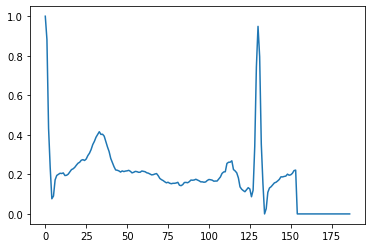

In [9]:
#Normal ECG
plt.plot(X_data.loc[100,:])

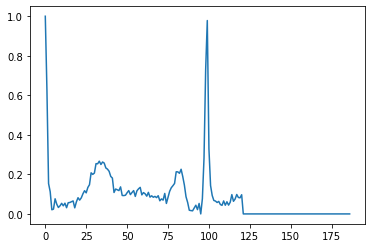

In [10]:
#Abnormal ECG
plt.plot(X_data.loc[6000,:])

In [11]:
y_data.value_counts()

1.0    10506
0.0     4046
Name: 187, dtype: int64

# Splitting Data & Setting "y" Categorical

In [12]:
dfX_train, dfX_test, y_train, y_test = train_test_split(X_data, y_data, shuffle=True, train_size=0.8, random_state = 42)

In [13]:
y_test

2069     0.0
6174     1.0
11676    1.0
5407     1.0
11090    1.0
        ... 
12476    1.0
11461    1.0
11360    1.0
3958     0.0
5440     1.0
Name: 187, Length: 2911, dtype: float64

In [14]:
#Preparing the train dataset including "y" before balancing the classes.
df_train = pd.concat([dfX_train, pd.Series(y_train)], axis=1)

In [15]:
df_train[187].value_counts()

1.0    8429
0.0    3212
Name: 187, dtype: int64

# Balancing Classes in Train Set

In [16]:
from sklearn.utils import resample

df_0=(df_train[df_train[187]==0])
df_1=(df_train[df_train[187]==1]).sample(n=8400,random_state=42)

#resampling minority class with replacement
df_0_upsample=resample(df_0,replace=True,n_samples=8400,random_state=123)

#balanced df
df_train_balanced=pd.concat([df_0_upsample,df_1])

#shuffling rows in balanced df
df_train_shuffled=df_train_balanced.sample(frac=1).reset_index(drop=True)

In [17]:
df_train_shuffled[187].value_counts()

1.0    8400
0.0    8400
Name: 187, dtype: int64

In [18]:
X_train_proc = df_train_shuffled.iloc[:,:186]
y_train_proc = df_train_shuffled.iloc[:,187]

# Formatting Train and Test

In [19]:
#X_train_proc comes from rebalancing classes in train_set above
X_train = X_train_proc.iloc[:,:186].values

#dfx_test comes from splitting train/test section
X_test = dfX_test.iloc[:,:186].values


In [20]:
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [21]:
y_train_cat=to_categorical(y_train_proc)
y_test_cat=to_categorical(y_test)

# Convolutional NN

# Network Definition







In [22]:
def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    #conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    #conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(conv1_1)
    #conv2_1=BatchNormalization()(conv2_1)
    #pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    #conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    #conv3_1=BatchNormalization()(conv3_1)
    #pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool1)
    #dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(flatten)
    main_output = Dense(2, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train, epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [23]:
model,history=network(X_train,y_train_cat,X_test,y_test_cat)

Epoch 1/40
525/525 [==============================] - 34s 3ms/step - loss: 0.4961 - accuracy: 0.7579 - val_loss: 0.3512 - val_accuracy: 0.8502
Epoch 2/40
525/525 [==============================] - 1s 3ms/step - loss: 0.3428 - accuracy: 0.8577 - val_loss: 0.3244 - val_accuracy: 0.8355
Epoch 3/40
525/525 [==============================] - 1s 3ms/step - loss: 0.2521 - accuracy: 0.9019 - val_loss: 0.2046 - val_accuracy: 0.9172
Epoch 4/40
525/525 [==============================] - 1s 3ms/step - loss: 0.2110 - accuracy: 0.9224 - val_loss: 0.1582 - val_accuracy: 0.9426
Epoch 5/40
525/525 [==============================] - 1s 3ms/step - loss: 0.1542 - accuracy: 0.9496 - val_loss: 0.1801 - val_accuracy: 0.9248
Epoch 6/40
525/525 [==============================] - 1s 3ms/step - loss: 0.1357 - accuracy: 0.9546 - val_loss: 0.1213 - val_accuracy: 0.9560
Epoch 7/40
525/525 [==============================] - 1s 3ms/step - loss: 0.1157 - accuracy: 0.9624 - val_loss: 0.1238 - val_accuracy: 0.9519
Epoch

# Model Evaluation

In [24]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()

    #Luis: Changed from strings to integer
    target_names=[0, 1]
    
    #y_true=[]
    #for element in y_test:
    #    y_true.append(np.argmax(element))
    #prediction_proba=model.predict(X_test)
    #prediction=np.argmax(prediction_proba,axis=1)
    #cnf_matrix = confusion_matrix(y_true, prediction)
    

Accuracy: 97.94%


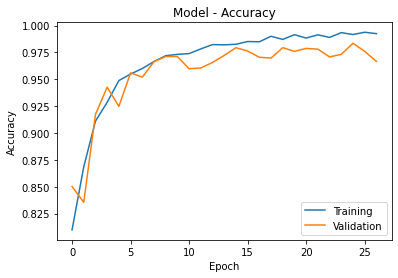

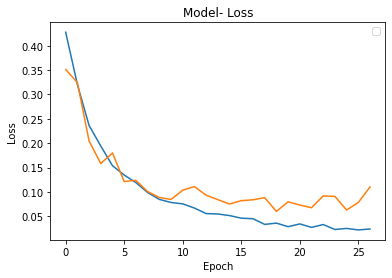

In [25]:
evaluate_model(history,X_test,y_test_cat,model)

In [ ]:
y_pred=model.predict(X_test)
#y_pred

In [ ]:
#y_test

Normalized confusion matrix


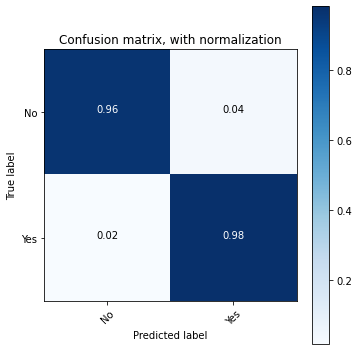

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_cat.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5, 5))
plot_confusion_matrix(cnf_matrix, classes=['No', 'Yes'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

In [ ]:
target_names = ['No', 'Yes']
print(classification_report(y_test_cat.argmax(axis=1), y_pred.argmax(axis=1),target_names=target_names))

              precision    recall  f1-score   support

          No       0.95      0.96      0.96       834
         Yes       0.98      0.98      0.98      2077

    accuracy                           0.97      2911
   macro avg       0.97      0.97      0.97      2911
weighted avg       0.98      0.97      0.97      2911

